In [2]:
# import classy module
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
#import corner
import pandas as pd
import emcee
import tqdm

This notebook is composed with reference to the "CLASS" reference notebooks and this source on MCMC analysis (https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html)

Github copilot has been used to write better comments. (I'm not sure why it's doing it, but I actually can't figure out how to disable this "feature". It is not being used to write code.)

In [3]:
#Data has been obtained from the Planck Legacy Archive: https://pla.esac.esa.int/pla/#cosmology 
#The data is the power spectrum of the CMB temperature anisotropies, which is a function of the multipole moment l.

data_file = '~/physics/COM_PowerSpect_CMB-TT-full_R3.01_with_header.txt'
data = pd.read_csv(data_file, sep='\s+', comment='#')
data = data.head(2499)

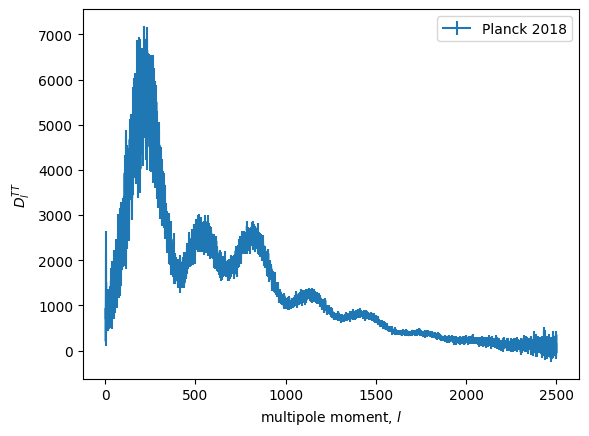

In [5]:
#Visualize the Planck 2018 data

errorbars = [data['-dDl'], data['+dDl']]
plt.errorbar(data['l'], data['Dl'], yerr = errorbars, label='Planck 2018')
plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

Because we don't have an accessible analytical model of the CMB temperature anisotropy, we're going to use the CLASS simulator to define our model for the MCMC. 

CLASS code and documentation can be found here: https://lesgourg.github.io/class_public/class.html#documentation
They request the following paper be cited when the software is use in publication: https://arxiv.org/abs/1104.2933

# Functions to define our model and calculate log-likelihood

In [151]:
multipole = data['l'].astype(int)
def model(theta, ells = multipole):
    '''
    Define a cosmological model we'll use to fit the PLANCK data.
    Inputs:
    theta: array of floats, model parameters
    ells: array of integers, multipole moments at which to evaluate the model (included for completion)
    Returns:
    LambdaCDM: CLASS instance, the model
    '''
    # for the first iteration of this code, let's just use the unaltered LambdaCDM model
    omega_b, omega_cdm, h, A_s, n_s, tau_reio, amp= theta
    #Initiate CLASS
    LambdaCDM = Class()
    # pass model parameters
    LambdaCDM.set({'omega_b':omega_b,'omega_cdm':omega_cdm,'h':h,'A_s':A_s,'n_s':n_s,'tau_reio':tau_reio})
    #Set CLASS generator settings
    LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})

    # run class - this creates our model
    LambdaCDM.compute()

    return LambdaCDM
    # get the CMB power spectrum

def get_cls(cmb_model):
    '''
    Get the CMB Temperature power spectrum from a CLASS model
    Inputs:
    cmb_model: CLASS instance, a cosmological model
    Returns:
    cls: array of floats, CMB Temperature power spectrum values
    '''
    all_cls = cmb_model.lensed_cl(2500)['tt'] #ls start at 0, so this gives cls up to l = 2500
    cls = all_cls[2:] #Our data start at l = 2
    cls_microK =cls*10**12 #Convert from K^2 to microKelvin sqaured to match Planck's units
    return cls_microK

def get_Dls(theta):
    '''
    Takes a set of cosmological parameters and returns the CMB temperature power spectrum in Dls (to match the Planck data)
    Inputs:
    theta: array of floats, model parameters
    Returns:
    Dls: array of floats, CMB temperature power spectrum values C_l*l*(l+1)/(2*pi)
    '''
    omega_b, omega_cdm, h, A_s, n_s, tau_reio, amp = theta
    CMB_model = model(theta)
    cls = get_cls(CMB_model)
    simulated_ls = CMB_model.lensed_cl(2500)['ell'] #ls start at 0, so this gives cls up to l = 2500
    l = simulated_ls[2:]
    Dls = amp*l*(l+1)*cls/(2*np.pi)
    return Dls

def log_likelihood(dls, x, y, yerr_up, yerr_down, amp):
    # get the model Dl for the given 'l' (passed as x). The index of each l is l-2, and l starts at 2.
    
    indeces = np.linspace(0, 2498, 2499).astype(int)
    model_y = dls[indeces]
    # calculate the likelihood
    y_err = yerr_down + yerr_up
    chi2 = np.sum((y - model_y)**2 / (y_err**2))

    ln_like = -0.5*chi2
    return ln_like

def check_priors(theta):
    # Prior ranges are inspired by the 1-sigma ranges summarized in this paper:https://www.aanda.org/articles/aa/pdf/2019/03/aa34060-18.pdf
    # I've taken the largest reported 1-sigma range for each parameter used the precision on the last digit to determine the prior (this makes them slightly assymetric in terms of amount above/below the 1 sigma interval, but I'm okay with that).
    omega_b, omega_cdm, h, A_s, n_s, tau_reio, amp = theta
    # LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
    # if (not (omega_b/h**2 + omega_cdm/h**2) < 1):
    #     #Make sure we don't overload the total energy density
    #     return False
    if not(0.0221 < omega_b <0.0225):
        return False
    if not(0.11 < omega_cdm <0.13):
        return False
    if not(0.65 < h <0.69):
        return False
    if not (0.04 < tau_reio < 0.09):
        return False
    if not(0.95 < n_s <0.97):
        return False
    if not(1.5e-9 < A_s <3.5e-9): 
        #print('A_s bound failed')  
        #Choosing a larger range here because the parameters used in the CLASS example vary more widely than those in the paper I used for the priors 
        return False
    if not(0.95 < n_s <0.98):
        #The paper does not address power spectrum tilt
        return False
    return True

# Based on the errors when running the MCMC below, it looks like we need to at least include consistency relations based on the actual cosmological relationships. This will be Monday's problem.

def ln_prob(theta, x, y, yerr_up, yerr_down):
    omega_b, omega_cdm, h, A_s, n_s, tau_reio, amp= theta
    # Check if this set of parameters is allowed
    possible = check_priors(theta)
    if not possible:
        return -np.inf
    
    dls = get_Dls(theta)

    # get the likelihood
    ln_likelihood = log_likelihood(dls, x, y, yerr_up, yerr_down, amp)
    return ln_likelihood


# Set up the MCMC Sampler
This code, as well as the MCMC running function, structured absed on the MCMC tutorial cited above

In [137]:
def run_sampler(p0, nwalkers, niter, ndim, lnprob):
    # Define your sampler, giving it the likelihood and data
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (data['l'], data['Dl'], data['+dDl'], data['-dDl']))
    
    # The burn-in sample allows us to start off with a better 'initial guess' for our overall analysis
    print("Running burn-in...")
    burn_length = 10 # Low for testing purposes
    p0, _, _ = sampler.run_mcmc(p0, burn_length)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [162]:
# Set up you 'guess' for the MCMC (IE, the first theta)
theta_start = np.array([0.0223828, 0.1201075, 0.67810, 2.100549e-09, 0.9660499, 0.05430842, np.pi*2]) #These are the values from the CLASS example, and a guess for  an amplitude conversion factor

# Set up the number of walkers and iterations for each walker
n_dim  = len(theta_start)
n_walkers = 20

# Each walker will start at a 1e-7 fluctuation from the guess, except for the A_s parameter which will start at a 1e-10 fluctuation, and the amplitude parameter which has a much larger fluctuation
p0 = np.array([np.array(theta_start) + 1e-7 * np.random.randn(n_dim) for i in range(n_walkers)])
a_s = theta_start[3]
for i in range(n_walkers):
    p0[i,3] = a_s + 1e-10 * np.random.rand()
    p0[i,6] = 9.5 + 0.1 * np.random.rand()

In [163]:
n_iterations = 10 # This is a low number for testing purposes. We will increase it later.

# Run the MCMC
sampler, pos, prob, state = run_sampler(p0, n_walkers,n_iterations, n_dim, ln_prob)
print(prob)

Running burn-in...
Running production...
[-1674.17428375  -358.4996253   -903.36654025 -4098.03889
 -5605.21327401 -6039.50634943 -3409.32567713  -957.02342747
 -2453.50353652 -1720.96107534  -340.79244854 -3122.06999447
  -365.16352448 -4264.89017863  -338.18195947  -344.1266086
 -1582.59622986 -2638.23740506  -367.15194769 -1080.07125226]


In [ ]:
# make traceplots for each parameter to assess convergence - Each of our walkers is a different chain, so we can test walkers against one another.

In [165]:
# Plot you MCMC results

Dls = data['Dl']
ls = data['l']

def plotter(sampler,ls = ls, dls=Dls):
    plt.ion()
    plt.plot(ls, dls,label="$D_l^{TT}$")
    samples = sampler.flatchain
    for (n, theta) in enumerate(pos):
        if (prob[n] > -np.inf):
            Dls = get_Dls(theta)
            plt.plot(ls, Dls, color="r", alpha=0.1)
        #If this set of parameters isn't allowed, do nothing
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('l')
    plt.ylabel("$D_l^{TT}$")
    plt.legend()
    plt.show()

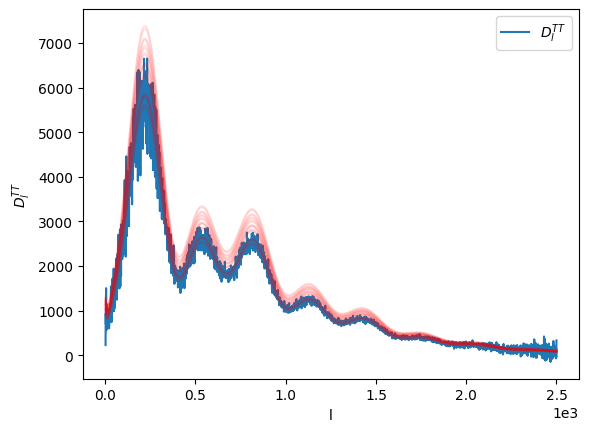

In [166]:
plotter(sampler)

In [193]:
samples = sampler.flatchain
theta_max = samples[np.argmax(sampler.flatlnprobability)]


AttributeError: 'EnsembleSampler' object has no attribute 'acceptancefraction'

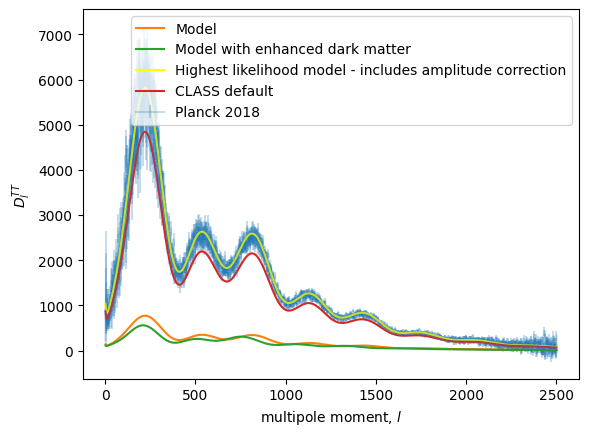

In [192]:
# Check CLASS' solution for the standard set of parameters against the PLANCK data

plt.errorbar(data['l'], data['Dl'], errorbars, label='Planck 2018', alpha=0.25)

theta_cdm = [0.0223828, 0.1201075, 0.67810, 2.100549e-09, 0.9660499, 0.05430842, 1]
dls = get_Dls(theta_cdm)#*10**12 # Convert to microKelvin squared to match Planck's units
plt.plot(ls, dls, label='Model')

theta_cdm_dm = [0.0223828, 0.2201075, 0.67810, 2.100549e-09, 0.9660499, 0.05430842, 1]
dls_dm = get_Dls(theta_cdm_dm)
plt.plot(ls, dls_dm, label='Model with enhanced dark matter')
#We see from this that even though changing the DM content will raise the peaks, it will not do so significantly enough to match the data, and also results in moved peak locations.

dls_bf = get_Dls(theta_max)#*10**12.85# We're probably missing a unit conversion here
plt.plot(ls, dls_bf, label='Highest likelihood model - includes amplitude correction', color='yellow', alpha=1.)

default_params = Class()
default_params.set({'output':'tCl, lCl', 'lensing':'yes'})
default_params.compute()
ells = default_params.lensed_cl(2500)['ell'][2:]
dls_default_params = (10**12)*default_params.lensed_cl(2500)['tt'][2:]*ells*(ells+1)
plt.plot(ls, dls_default_params, label='CLASS default')

plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

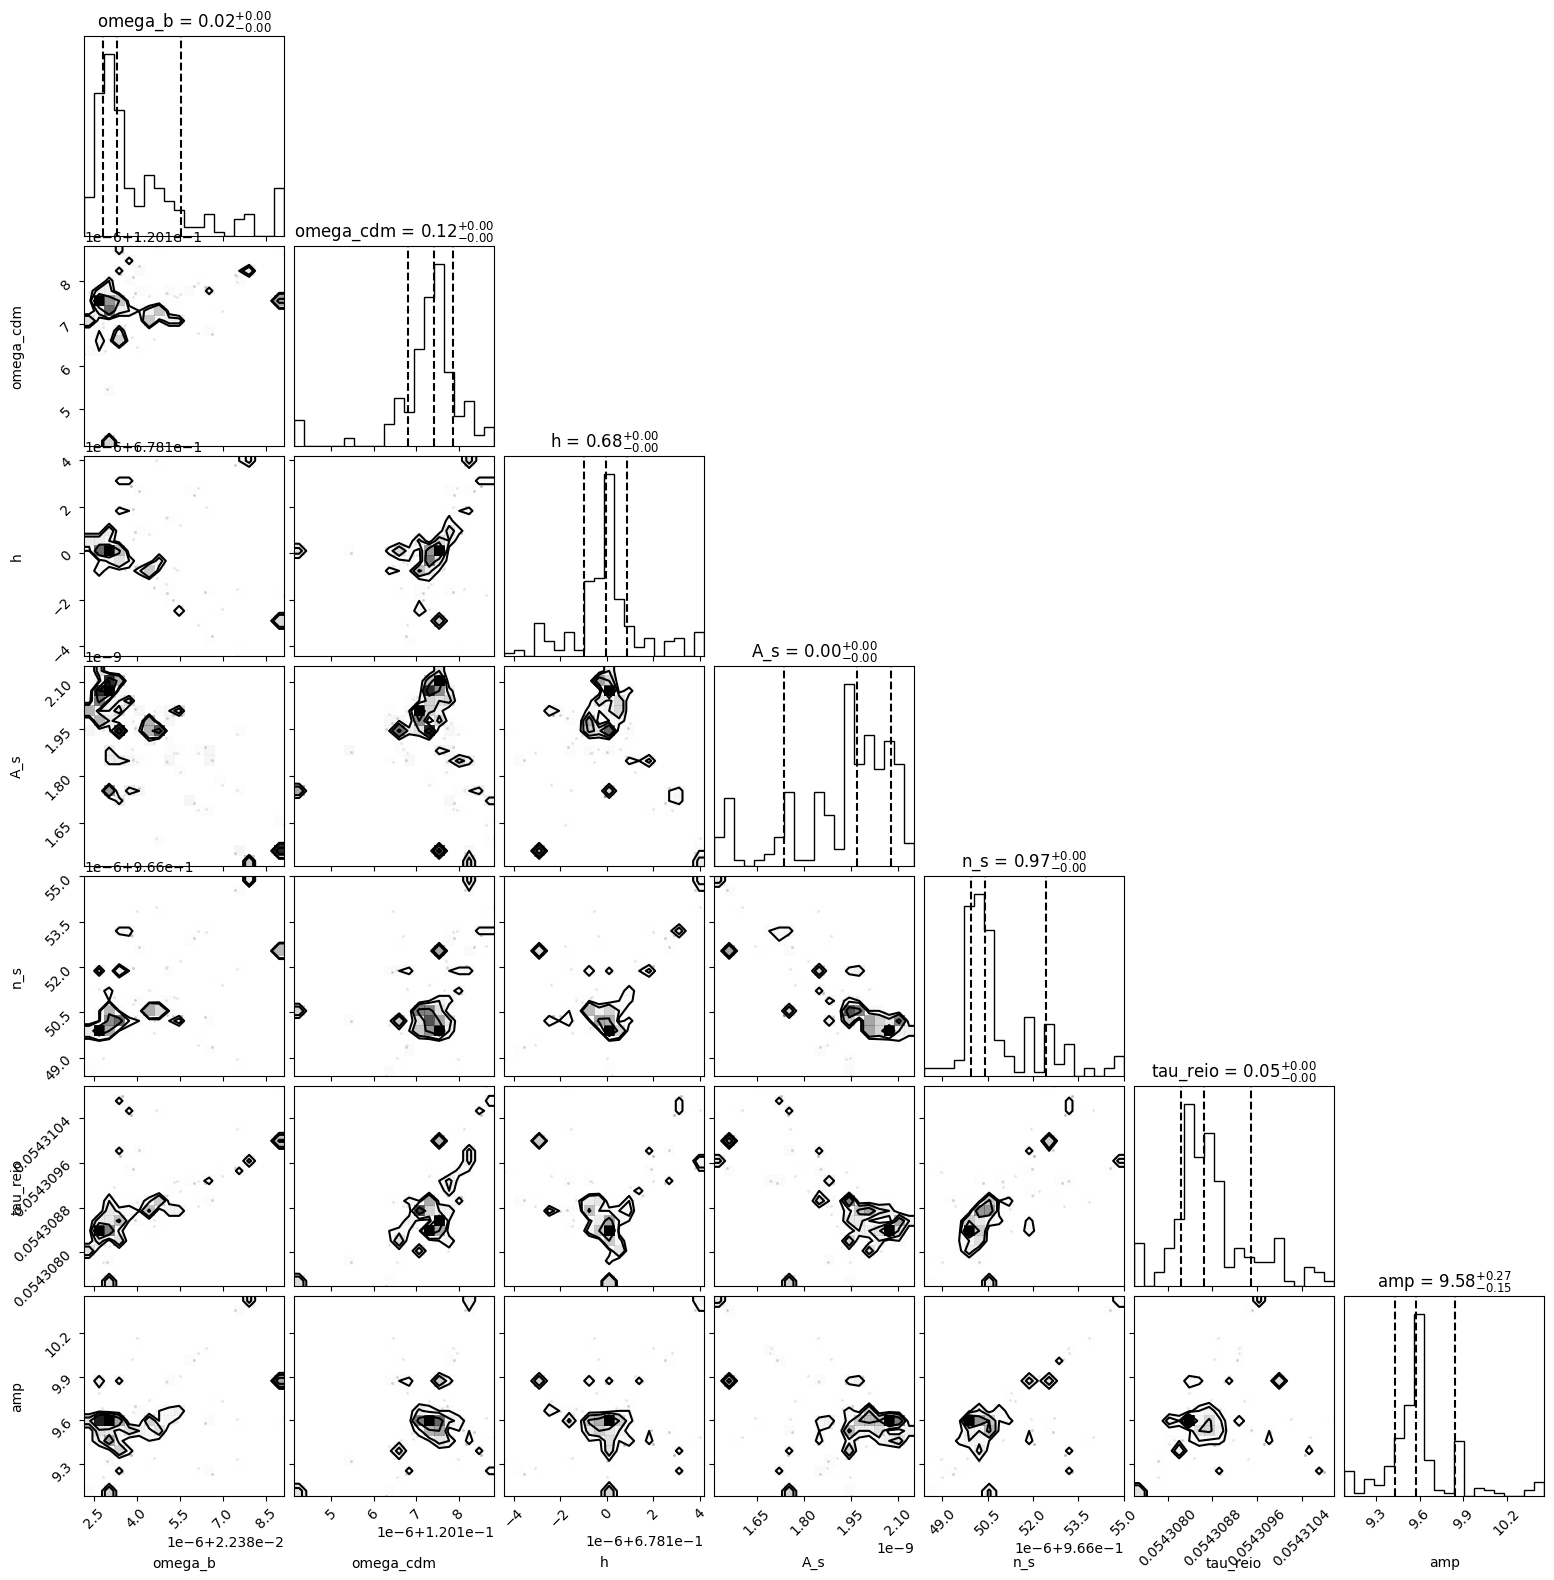

In [177]:
import corner
labels = ['omega_b', 'omega_cdm', 'h', 'A_s', 'n_s', 'tau_reio', 'amp']
fig = corner.corner(samples, show_titles=True, labels=labels, plot_datapoints = True, quantiles=[0.16, 0.5, 0.84])

# Content of the original "warmup" notebook

In [39]:
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
#LambdaCDM.set({'omega_b':2.23829144e-02,'omega_cdm':1.20107561e-01,'h':6.78100155e-01,'A_s':-1.28804382e-08,'n_s':0.9660499,'tau_reio':0.05430842})
# array([ 2.23829144e-02,  1.20107561e-01,  6.78100155e-01, -1.28804382e-08, 9.66050059e-01,  5.43084815e-02])

LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})
# run class
LambdaCDM.compute()

In [40]:
# get all C_l output
cls = LambdaCDM.lensed_cl(2500)
# To check the format of cls
cls.keys()

dict_keys(['tt', 'ee', 'te', 'bb', 'pp', 'tp', 'ell'])

In [41]:
ll = cls['ell'][2:]
clTT = cls['tt'][2:]
clEE = cls['ee'][2:]
clPP = cls['pp'][2:]

In [42]:
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib.pyplot as plt
from math import pi

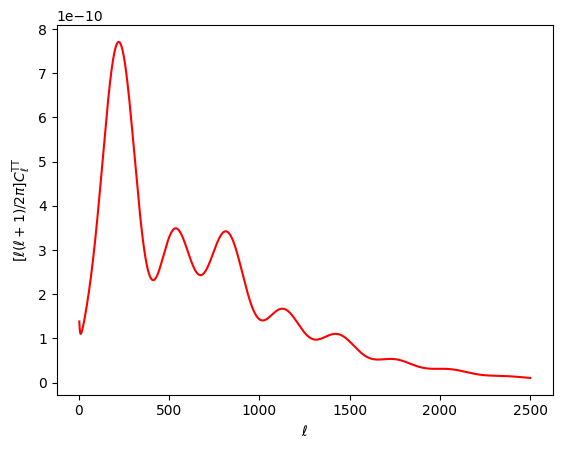

In [44]:
# plot C_l^TT
plt.figure(1)
#plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
plt.plot(ll,clTT*ll*(ll+1)/2./pi,'r-')

In [46]:
# get P(k) at redhsift z=0
import numpy as np
kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk.append(LambdaCDM.pk(k*h,0.)*h**3) # function .pk(k,z)

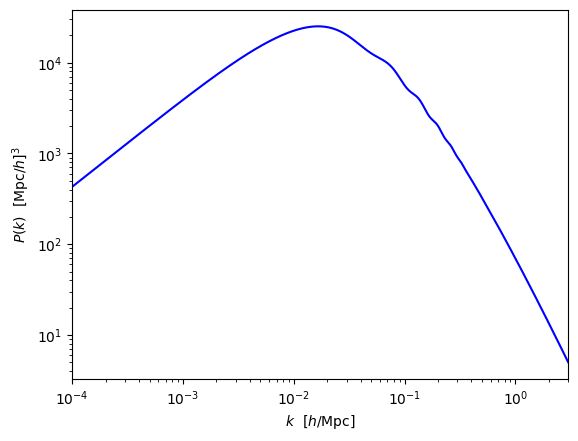

In [47]:
# plot P(k)
plt.figure(2)
plt.xscale('log');plt.yscale('log');plt.xlim(kk[0],kk[-1])
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
plt.plot(kk,Pk,'b-')

In [ ]:
# optional: reset parameters to default in case you want 
# to set different parameters and rerun LambdaCDM.compute()
LambdaCDM.empty()